<a href="https://colab.research.google.com/github/lywgit/rlbook-hands-on/blob/main/04_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#04 Q learing
- tabular Q learning
- deep Q learning (not yet)

In [1]:
!pip install gymnasium
!pip install ale-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.1 MB/s eta 0:00:00


### Tabular Q learning

In [17]:
from os import truncate
# copied and modified from the rlbook Chap6: frozenlake_q_learning.py
import gymnasium as gym
import collections
from torch.utils.tensorboard import SummaryWriter

ENV_NAME = "FrozenLake-v1"
GAMMA = 0.95
ALPHA = 0.2 # 學習速率
TEST_EPISODES = 20


class Agent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.state, _ = self.env.reset()
        self.values = collections.defaultdict(float) # Q (action value)
        # 和前面的範例不同：沒有存 transit(s,a)->s->int 和 reward(s,a,s')->float
        # 不用擔心 observation space 太大的儲存問題

    def sample_env(self):
        action = self.env.action_space.sample()
        old_state = self.state
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        is_done = terminated or truncated
        self.state = self.env.reset()[0] if is_done else new_state
        return (old_state, action, reward, new_state)

    def best_value_and_action(self, state):
        best_value, best_action = None, None
        for action in range(self.env.action_space.n):
            action_value = self.values[(state, action)] # Q(s,a)
            if best_value is None or best_value < action_value:
                best_value = action_value
                best_action = action
        return best_value, best_action

    def value_update(self, s, a, r, next_s):
        best_v, _ = self.best_value_and_action(next_s)
        new_val = r + GAMMA * best_v
        old_val = self.values[(s, a)]
        self.values[(s, a)] = old_val * (1-ALPHA) + new_val * ALPHA
        # 優化：增加穩定性，平滑更新 Q 值

    def play_episode(self, env):
        total_reward = 0.0
        state, _ = env.reset()
        while True:
            _, action = self.best_value_and_action(state)
            new_state, reward, terminated, truncated, _ = env.step(action)
            is_done = terminated or truncated
            total_reward += reward
            if is_done:
                break
            state = new_state
        return total_reward


if __name__ == "__main__":
    test_env = gym.make(ENV_NAME)
    agent = Agent()
    writer = SummaryWriter(comment="-q-learning")

    iter_no = 0
    best_reward = 0.0
    while True:
        iter_no += 1
        # tabular Q learning: 用 (s,a,r,s') 資料來平滑更新 Q(s,a) 的估計
        s, a, r, next_s = agent.sample_env()
        agent.value_update(s, a, r, next_s)

        # 驗證（Q 越好則 best action 越好，驗證分數越高）
        reward = 0.0
        for _ in range(TEST_EPISODES):
            reward += agent.play_episode(test_env)
        reward /= TEST_EPISODES
        writer.add_scalar("reward", reward, iter_no)
        if reward > best_reward:
            print("Best reward updated %.3f -> %.3f" % (best_reward, reward))
            best_reward = reward
        if reward > 0.80:
            print("Solved in %d iterations!" % iter_no)
            break
    writer.close()


Best reward updated 0.000 -> 0.050
Best reward updated 0.050 -> 0.100
Best reward updated 0.100 -> 0.150
Best reward updated 0.150 -> 0.200
Best reward updated 0.200 -> 0.250
Best reward updated 0.250 -> 0.300
Best reward updated 0.300 -> 0.350
Best reward updated 0.350 -> 0.400
Best reward updated 0.400 -> 0.550
Best reward updated 0.550 -> 0.600
Best reward updated 0.600 -> 0.650
Best reward updated 0.650 -> 0.700
Best reward updated 0.700 -> 0.800
Best reward updated 0.800 -> 0.950
Solved in 10764 iterations!


### Visualize agent play


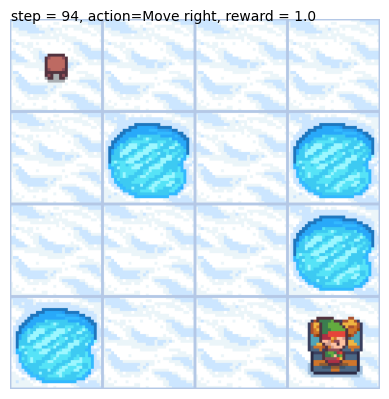

In [20]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

env = gym.make(ENV_NAME, render_mode='rgb_array')
state, info = env.reset()
is_done = False
i_step = 0
action_text_dict = {0: 'Move left', 1: 'Move down', 2: 'Move right', 3: 'Move up'}
while not is_done:
    i_step += 1
    action = agent.best_value_and_action(state)[1]
    state, reward, turminated, truncated, info = env.step(action)
    is_done = turminated or truncated

    clear_output(wait=True)
    img = env.render()
    plt.imshow(img)
    # optionaly remove grid and ticks, and add some info
    plt.axis('off')
    plt.text(0, 0, f"step = {i_step}, action={action_text_dict[action]}, reward = {reward}")
    plt.show()
    time.sleep(0.5)

env.close()

# 看起來有點笨？